In [1]:
import sys 
sys.path.append("../")
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import misc, dataloader
import glob, os
import cv2
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from PIL import Image
from pytiff import Tiff

In [2]:
def lung_segment(image, pix_spc):
    mask_air = np.zeros_like(image)
    mask_air[image > 20] = 1.
    y_min, y_max, h_max = image.shape[0], 0, 0
    idx = 0
    n_sl = mask_air.shape[0] # No. slice
    col, row = mask_air.shape[:2]
    mask = np.zeros((mask_air.shape[0], mask_air.shape[2]), np.uint8)
    for slice in range(image.shape[1]//2 -10, image.shape[1]//2 + 10):
        _, img_bw = cv2.threshold((mask_air[:, slice,:]*255.).astype(np.uint8), 150, 255, cv2.THRESH_BINARY_INV)
        _, contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#         plt.imshow(img_bw, cmap="gray")
#         plt.show()       
        for i in range(len(contours)):
            area = cv2.contourArea(contours[i])
            (x,y,w,h) = cv2.boundingRect(contours[i])
#             if 5000/pix_spc**2 <= area <= 35000/pix_spc**2:
#                 print(area,x,y,w,h)
            if 5000/pix_spc**2 <= area <= 35000/pix_spc**2 and x+y != 0 and x+w < row \
                    and 70/pix_spc<w<h<=370/pix_spc and h> 150/pix_spc and 25<(x+w//2) <95\
                    and  ((n_sl*0.5<y +h//2 < n_sl*0.9 and col>1.5*row) or (h < n_sl and col<=1.5*row)):
                if y < y_min:
                    y_min = y
                if y+h > y_max:
                    y_max = y+h
                if h > h_max:
                    h_max = h
                    idx = slice
                mask = cv2.drawContours(mask, [contours[i]], -1, (255), -1)
                

    return idx, y_min, y_max, mask

def check_path_dicom(pathCTdicom_, pathSegdicom_, dirName, fileList):
    if (len(fileList) > 1) :
        pathCTdicom_ = dirName
    elif (len(fileList) == 1) and "Segmentation" in dirName:
        pathSegdicom_ = dirName
    
    return pathCTdicom_, pathSegdicom_

(237, 128, 128) (237, 128, 128)
(86, 128, 128) (86, 128, 128)
(96, 128, 128) (96, 128, 128)


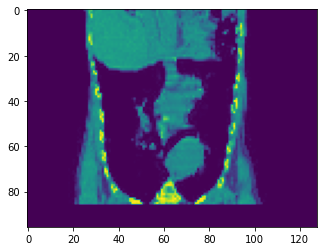

(206, 128, 128) (206, 128, 128)
(80, 128, 128) (80, 128, 128)
(96, 128, 128) (96, 128, 128)


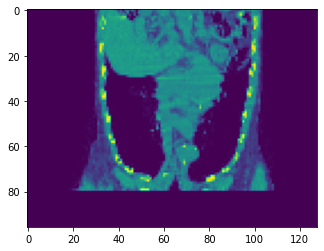

(237, 128, 128) (237, 128, 128)
(64, 128, 128) (64, 128, 128)
(96, 128, 128) (96, 128, 128)


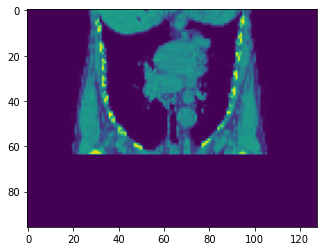

(337, 128, 128) (337, 128, 128)
(83, 128, 128) (83, 128, 128)
(96, 128, 128) (96, 128, 128)


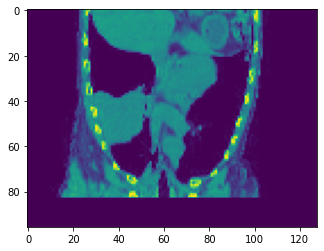

(356, 128, 128) (356, 128, 128)
(69, 128, 128) (69, 128, 128)
(96, 128, 128) (96, 128, 128)


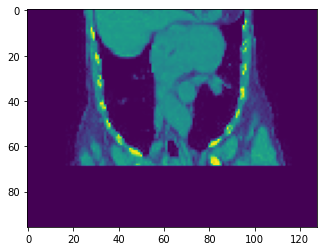

In [10]:
Path = "D:\\LungCancer\\2020-lung-cancer\\New folder\\20190530_CT\\Imgs"
path2save = "D:\\LungCancer\\2020-lung-cancer\\New folder\\data"
size_desired = 128
n_slc_desired = 96

folders = os.listdir(Path)
for foldername in folders:
    folder_dir = os.path.join(Path, foldername)
    files = os.listdir(folder_dir)
    patient_CT = []
    for filename in files:
        img = cv2.imread(os.path.join(folder_dir, filename), 0)
        patient_CT.append(img)
    patient_CT = np.asarray(patient_CT)
    pix_resampled_CT, _ = misc.resample(patient_CT, 3.75, 
                                        500/patient_CT.shape[1], 
                                        500/patient_CT.shape[2], 
                                        [3.90625,3.90625,3.90625])
    idx, y_min, y_max, mask = lung_segment(pix_resampled_CT, 3.90625)
    
    folder_dir = folder_dir.replace("Imgs", "GT")
    files = os.listdir(folder_dir)
    GT = []
    idx = 0
    for j, filename in enumerate(files):
        
        tif = Tiff(os.path.join(folder_dir, filename))
        image = np.array(tif).astype(np.uint8)
        _, image = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)
        
        _, contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros(image.shape)
        for i in range(len(contours)):
            x,y,w,h = cv2.boundingRect(contours[i])
            if 40 < x < image.shape[0] - 40:
                mask = cv2.drawContours(mask, [contours[i]], -1, (255), -1)
                idx = j
        mask = cv2.resize(mask, (128, 128))
        GT.append(mask)
    GT = np.asarray(GT).astype(np.float32)
    #GT[GT > 200] = 1000
    GT_resampled, _ = misc.resample(GT, 3.75, 
                                        500/GT.shape[1], 
                                        500/GT.shape[2], 
                                        [3.90625,3.90625,3.90625])
    GT_resampled[GT_resampled > 100] = 255
    GT_resampled[GT_resampled <= 100] = 0
    
    pix_resampled_CT[pix_resampled_CT > 255] = 255
    pix_resampled_CT[pix_resampled_CT < 0] = 0
    
    pix_resampled_CT = (pix_resampled_CT - pix_resampled_CT.min())/(pix_resampled_CT.max() - pix_resampled_CT.min())
    GT_resampled = (GT_resampled - GT_resampled.min())/(GT_resampled.max() - GT_resampled.min())
    #GT_resampled = GT_resampled[::-1]
#     print(patient_CT.shape, GT.shape)
#     print(pix_resampled_CT.shape, GT_resampled.shape)
#     print(idx, y_min, y_max)
    print(pix_resampled_CT.shape, GT_resampled.shape)
    if "Case_1" in foldername: 
        pix_resampled_CT = pix_resampled_CT[y_max-n_slc_desired+10: y_max, :, :]
        GT_resampled = GT_resampled[y_max-n_slc_desired+10: y_max, :,]
    else:
        pix_resampled_CT = pix_resampled_CT[y_min: y_max, :, :]
        GT_resampled = GT_resampled[y_min: y_max, :,]        

    pix_resampled_CT  = pix_resampled_CT.astype(np.float32)
    GT_resampled = GT_resampled.astype(np.float32)
    print(pix_resampled_CT.shape, GT_resampled.shape)
    pix_resampled_CT, GT_resampled = dataloader.padding_image(pix_resampled_CT, GT_resampled, n_slc_desired)

    print(pix_resampled_CT.shape, GT_resampled.shape)
    np.save(os.path.join(path2save, "Imgs", foldername+ ".npy"), pix_resampled_CT)
    np.save(os.path.join(path2save, "GT", foldername+ ".npy"), GT_resampled) 
        
# #         print(dirName[-7:])        
# #         print(idx, y_min, y_max, y_max-y_min)
# #         print(list_wrong_measurement)
# #         img_CT = (pix_resampled_CT- pix_resampled_CT.min()) / (pix_resampled_CT.max() - pix_resampled_CT.min())*255.
# #         #img_PET = (pix_resampled_PET- pix_resampled_PET.min()) / (pix_resampled_PET.max() - pix_resampled_PET.min())*255.
# #         #, img_PET.shape[:, idx,:], mask.shape)
# # #         plt.imshow(out, cmap="gray")
# # #         plt.show()
    #plt.imshow(np.hstack((pix_resampled_CT[idx], GT_resampled[idx])), cmap="gray")
#     for i in range(GT_resampled.shape[0]):
#         print(i, GT_resampled[i].min(), GT_resampled[i].max())
#         plt.hist(GT_resampled[i].reshape(-1,1), bins=4)
#         plt.show()
    if "Case_4" in foldername:
        idx = 250
    if "Case_5" in foldername:
        idx = 280    
    #plt.imshow(np.hstack((pix_resampled_CT[idx-10],GT_resampled[idx-10])), cmap="gray")
    plt.imshow(pix_resampled_CT[:, 64,:])
    plt.show()
